## Compile all available T, S, DO data (already processed)

In [4]:
# Load Packages

import xarray as xr 
import pandas as pd
import numpy as np
import gsw as gsw
from netCDF4 import Dataset
import sys
sys.path.append('/Users/ko389/Documents/Arctic_Water_Masses/Functions_general/')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import seaborn as sn
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo


**1. Combine UDASH-GLODAP data and Argo data**

In [5]:
# Average UDASH + GLODAP data to 10m bins

chunk_size = 100000  # Adjust the chunk size based on your system's memory capacity

# Create an empty DataFrame to store the results
udash_glodap = pd.DataFrame()

# Iterate over chunks of the original DataFrame
for chunk in pd.read_csv('/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/data/glodap_udash_combined.csv', chunksize=chunk_size):
    
    # Get depth intervals for each data point
    unique_depths = np.sort(chunk['depth'].unique())
    bin_edges = pd.cut(unique_depths, bins=range(0, int(unique_depths.max()) + 10, 10))
    bin_index = pd.IntervalIndex.from_arrays(bin_edges.categories.left, bin_edges.categories.right)
    bin_midpoints = bin_index.mid
    chunk['depth_interval'] = pd.cut(chunk['depth'], bins=bin_index)
    chunk['depth_interval'] = chunk['depth_interval'].astype(str) #This is needed to recognise depth_interval when grouping data by depth_interval.

    # mean of DO, T, S, lon, lat
    chunk_mean = chunk.drop(columns=['datetime', 'pressure', 'depth','udash_source']).groupby(['source', 'nprof', 'depth_interval']).mean().reset_index()
    # first of datetime
    chunk_first = chunk.drop(columns=['conservative_temperature', 'pressure', 'absolute_salinity','dissolved_oxygen','depth', 'longitude', 'latitude']).groupby(['source', 'nprof', 'depth_interval']).first().reset_index()
    # merge data
    chunk_combine = pd.merge(chunk_mean, chunk_first, on=['source','nprof', 'depth_interval'])
    # get midpoint of depth interval
    def get_midpoint_from_string(intervals_str):
        # Remove brackets and split by comma
        numbers = intervals_str.strip("()[]").split(", ")
        # Check if there are exactly 2 numbers
        if len(numbers) != 2:
            return float('nan')
        if len(numbers) == 2:
        # Convert to floats
            start, end = float(numbers[0]), float(numbers[1])
        # Calculate midpoint
            return (start + end) / 2
    chunk_combine['depth'] = chunk_combine['depth_interval'].apply(get_midpoint_from_string)
    chunk_combine.drop(columns=['depth_interval'], inplace=True)
    chunk_combine.dropna(subset=['longitude'], inplace=True) 
    # Append the processed chunk to the result DataFrame
    udash_glodap = pd.concat([udash_glodap, chunk_combine], ignore_index=True)

# Example usage
print(udash_glodap) 

         source   nprof  dissolved_oxygen  longitude  latitude  \
0        glodap       1               NaN     7.2270   80.5670   
1        glodap       1               NaN     7.2270   80.5670   
2        glodap       1               NaN     7.2270   80.5670   
3        glodap       1               NaN     7.2270   80.5670   
4        glodap       1               NaN     7.2270   80.5670   
...         ...     ...               ...        ...       ...   
8171493   udash  286502               NaN     6.9405   78.8152   
8171494   udash  286502               NaN     6.9405   78.8152   
8171495   udash  286502               NaN     6.9405   78.8152   
8171496   udash  286502               NaN     6.9405   78.8152   
8171497   udash  286502               NaN     6.9405   78.8152   

         absolute_salinity  conservative_temperature udash_source  \
0                33.474041                  0.478311          NaN   
1                35.149673                  2.457009          NaN   


In [6]:
# Average Argo data into 10m bins
 
# chunk_size = 100000  # Adjust the chunk size based on your system's memory capacity

# Create an empty DataFrame to store the results
argo = pd.DataFrame()

# Iterate over chunks of the original DataFrame
for chunk in pd.read_csv('/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/data/argo_processed.csv', chunksize=chunk_size):
    
    # Get depth intervals for each data point
    unique_depths = np.sort(chunk['depth'].unique())
    bin_edges = pd.cut(unique_depths, bins=range(0, int(unique_depths.max()) + 10, 10))
    bin_index = pd.IntervalIndex.from_arrays(bin_edges.categories.left, bin_edges.categories.right)
    bin_midpoints = bin_index.mid
    chunk['depth_interval'] = pd.cut(chunk['depth'], bins=bin_index)
    chunk['depth_interval'] = chunk['depth_interval'].astype(str) #This is needed to recognise depth_interval when grouping data by depth_interval.

    # mean of DO, T, S, lon, lat
    chunk_mean = chunk.drop(columns=['datetime', 'pressure', 'depth']).groupby(['source', 'nprof', 'depth_interval']).mean().reset_index()
    # first of datetime
    chunk_first = chunk.drop(columns=['insitu_temperature', 'pressure', 'practical_salinity','dissolved_oxygen','depth', 'longitude', 'latitude']).groupby(['source', 'nprof', 'depth_interval']).first().reset_index()
    # merge data
    chunk_combine = pd.merge(chunk_mean, chunk_first, on=['source','nprof', 'depth_interval'])
    # get midpoint of depth interval
    def get_midpoint_from_string(intervals_str):
        # Remove brackets and split by comma
        numbers = intervals_str.strip("()[]").split(", ")
        # Check if there are exactly 2 numbers
        if len(numbers) != 2:
            return float('nan')
        if len(numbers) == 2:
        # Convert to floats
            start, end = float(numbers[0]), float(numbers[1])
        # Calculate midpoint
            return (start + end) / 2
    chunk_combine['depth'] = chunk_combine['depth_interval'].apply(get_midpoint_from_string)
    chunk_combine.drop(columns=['depth_interval'], inplace=True)
    chunk_combine.dropna(subset=['longitude'], inplace=True) 
    # Append the processed chunk to the result DataFrame
    argo = pd.concat([argo, chunk_combine], ignore_index=True)

# Example usage
print(argo) 

      source  nprof   latitude  longitude  dissolved_oxygen  \
0       argo      1  63.314544  -0.074864               NaN   
1       argo      1  63.317097  -0.017259               NaN   
2       argo      1  64.988367   3.022000               NaN   
3       argo      1  65.943400   4.100400               NaN   
4       argo      1  64.316400   2.628400               NaN   
...      ...    ...        ...        ...               ...   
87479   argo    549  65.878176   0.363368               NaN   
87480   argo    549  64.332000  -1.497667               NaN   
87481   argo    549  65.843395   0.410763               NaN   
87482   argo    549  65.812845   0.284732               NaN   
87483   argo    549  65.812845   0.284732               NaN   

       insitu_temperature  practical_salinity                   datetime  \
0                9.236558           35.185149  2009-08-09 11:41:54+00:00   
1                7.981722           35.234196  2009-08-09 11:41:54+00:00   
2              

In [7]:
# Get TEOS -recommended T and S 
import gsw
argo['pressure'] = gsw.p_from_z(-argo['depth'].astype(float).values, argo['latitude'].values)
argo['absolute_salinity'] = gsw.SA_from_SP(argo['practical_salinity'].values,argo['pressure'].values,argo['longitude'].values,argo['latitude'].values)
argo['conservative_temperature'] = gsw.CT_from_t(argo['absolute_salinity'].values, argo['insitu_temperature'].values,argo['pressure'].values)
argo = argo.drop(columns=['insitu_temperature', 'practical_salinity'])

# Get datetime in format
argo['datetime'].astype('string')
argo['datetime'] = pd.to_datetime(argo['datetime'], errors='coerce',  utc=True)

In [8]:
# Combine ARGO and GLODAP

udash_glodap_argo = pd.concat([argo, udash_glodap], axis=0)
udash_glodap_argo

,source,nprof,latitude,longitude,dissolved_oxygen,datetime,depth,pressure,absolute_salinity,conservative_temperature,udash_source
0,argo,1,63.314544,-0.074864,NaN,2009-08-09 11:41:54+00:00,15.0,15.147180,35.352074,9.221835,NaN
1,argo,1,63.317097,-0.017259,NaN,2009-08-09 11:41:54+00:00,105.0,106.053665,35.402086,7.958291,NaN
2,argo,1,64.988367,3.022000,NaN,2010-04-02 12:56:52+00:00,1005.0,1017.434388,35.069008,-0.566519,NaN
3,argo,1,65.943400,4.100400,NaN,2010-04-26 12:48:56+00:00,1015.0,1027.651640,35.074707,-0.799701,NaN
4,argo,1,64.316400,2.628400,NaN,2010-04-02 12:56:52+00:00,1025.0,1037.682065,35.066685,-0.450690,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8171493,udash,286502,78.815200,6.940500,NaN,2000-08-20 00:00:00+00:00,955.0,NaN,35.068989,-0.523178,pan
8171494,udash,286502,78.815200,6.940500,NaN,2000-08-20 00:00:00+00:00,965.0,NaN,35.069970,-0.529454,pan
8171495,udash,286502,78.815200,6.940500,NaN,2000-08-20 00:00:00+00:00,975.0,NaN,35.070539,-0.545979,pan
8171496,udash,286502,78.815200,6.940500,NaN,2000-08-20 00:00:00+00:00,985.0,NaN,35.070464,-0.570112,pan


In [9]:
# Save extended udash

output_file_path = "/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/"
output_file_name = "compiled_argo_glodap_udash_10m_res.nc"
udash_glodap.to_xarray().to_netcdf(output_file_path + output_file_name)

print("DataFrame saved as NetCDF file successfully.")


DataFrame saved as NetCDF file successfully.


**2. Combine UDASH-GLODAP-ARGO data and ITP data**

In [10]:
# Average ITP data into 10m bins (reduces spatial bias in instrument sampling)

import pandas as pd
import numpy as np

# Assuming df is your DataFrame with 'depth', 'source', 'nprof', and other relevant columns
chunk_size = 100000  # Adjust the chunk size based on your system's memory capacity

# Create an empty DataFrame to store the results
itp = pd.DataFrame()

# Iterate over chunks of the original DataFrame
for chunk in pd.read_csv('/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/data/itp_processed.csv', chunksize=chunk_size):
    # Get depth intervals for each data point
    unique_depths = np.sort(chunk['depth'].unique())
    bin_edges = pd.cut(unique_depths, bins=range(0, int(unique_depths.max()) + 10, 10))
    bin_index = pd.IntervalIndex.from_arrays(bin_edges.categories.left, bin_edges.categories.right)
    bin_midpoints = bin_index.mid
    chunk['depth_interval'] = pd.cut(chunk['depth'], bins=bin_index)
    chunk['depth_interval'] = chunk['depth_interval'].astype(str) #This is needed to recognise depth_interval when grouping data by depth_interval.

    # mean of DO, T, S, lon, lat
    chunk_mean = chunk.drop(columns=['datetime', 'pressure', 'depth']).groupby(['source', 'nprof', 'depth_interval']).mean().reset_index()
    # first of datetime
    chunk_first = chunk.drop(columns=['potential_temperature', 'pressure', 'practical_salinity','dissolved_oxygen','depth', 'longitude', 'latitude']).groupby(['source', 'nprof', 'depth_interval']).first().reset_index()
    # merge data
    chunk_combine = pd.merge(chunk_mean, chunk_first, on=['source','nprof', 'depth_interval'])
    # get midpoint of depth interval
    def get_midpoint_from_string(intervals_str):
        # Remove brackets and split by comma
        numbers = intervals_str.strip("()[]").split(", ")
        # Check if there are exactly 2 numbers
        if len(numbers) != 2:
            return float('nan')
        if len(numbers) == 2:
        # Convert to floats
            start, end = float(numbers[0]), float(numbers[1])
        # Calculate midpoint
            return (start + end) / 2
    chunk_combine['depth'] = chunk_combine['depth_interval'].apply(get_midpoint_from_string)
    chunk_combine.drop(columns=['depth_interval'], inplace=True)
    chunk_combine.dropna(subset=['longitude'], inplace=True) 
    # Append the processed chunk to the result DataFrame
    itp = pd.concat([itp, chunk_combine], ignore_index=True)

# Example usage
print(itp)


        source   nprof  Unnamed: 0_x  potential_temperature  \
0          itp       1         250.0              -0.118700   
1          itp       2           0.5              -1.587250   
2          itp       2           6.5              -1.587160   
3          itp       2          97.0              -1.217436   
4          itp       2         107.5              -1.210880   
...        ...     ...           ...                    ...   
5232832    itp  110223         739.5               0.370850   
5232833    itp  110223         749.5               0.348650   
5232834    itp  110223         755.5               0.343450   
5232835    itp  110223          80.5              -0.867780   
5232836    itp  110223          91.0              -1.084691   

         practical_salinity  dissolved_oxygen  longitude  latitude  \
0                 34.521100               NaN  -131.6620   76.1139   
1                 29.067500               NaN  -141.3968   77.7939   
2                 29.069150      

In [11]:
itp.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'], inplace=True)


In [12]:
# Get TEOS -recommended T and S 
import gsw
itp['pressure'] = gsw.p_from_z(-itp['depth'].astype(float).values, itp['latitude'].values)
itp['absolute_salinity'] = gsw.SA_from_SP(itp['practical_salinity'].values,itp['pressure'].values,itp['longitude'].values,itp['latitude'].values)
itp['conservative_temperature'] = gsw.CT_from_pt(itp['absolute_salinity'].values,itp['potential_temperature'].values)
itp.drop(columns=['potential_temperature', 'practical_salinity'],inplace=True)

# Get datetime into datetime format
itp['datetime'].astype('string')
itp['datetime'] = pd.to_datetime(itp['datetime'], errors='coerce',  utc=True)


In [13]:
# Add extra ITP to UDASH-GLODAP-ARGO
# import xarray as xr
# udash_glodap_argo = xr.open_dataset('/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/compiled_argo_glodap_udash_10m_res.nc')
# udash_glodap_argo = udash_glodap_argo.to_dataframe()
udash_glodap_argo = pd.concat([udash_glodap_argo, itp], axis=0)

In [15]:
# Save as netcdf

#output_file_name = "final_compiled_glodap_udash_argo_itp_10m_res.nc"
#output_file_path = "/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/"
#udash_glodap_argo.to_xarray().to_netcdf(output_file_path + output_file_name)

#print("DataFrame saved as NetCDF file successfully.")

**3. Combine UDASH-GLODAP-ARGO-ITP data and extra cruise data (just MOSAiC for this analysis)**

In [16]:
# Load processed cruise data 
import xarray as xr
data_path = "/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/data/cruises_not_in_GLODAP/cruises_not_in_GLODAP.nc"
additional_cruises = xr.open_dataset(data_path).to_dataframe()

In [17]:
additional_cruises['datetime'] = pd.to_datetime(additional_cruises['datetime'], errors='coerce',  utc=True)
additional_cruises.drop(columns=['year', 'month', 'day','hour','minute','second'], inplace=True)


In [18]:
# Bin additional cruise data into 10m bins


# Calculate bin edges based on the depth range
bin_edges = range(0, int(additional_cruises['depth'].max()) + 10, 10)
additional_cruises['depth_interval'] = pd.cut(additional_cruises['depth'], bins=bin_edges)
additional_cruises['depth_interval'] = additional_cruises['depth_interval'].astype(str) #This is needed to recognise depth_interval when grouping data by depth_interval.

# mean of DO, T, S, lon, lat
additional_cruises_mean = additional_cruises.drop(columns=['datetime', 'depth']).groupby(['source', 'nprof', 'depth_interval']).mean().reset_index()
# first of datetime
additional_cruises_first = additional_cruises.drop(columns=['conservative_temperature',  'absolute_salinity','dissolved_oxygen','depth', 'longitude', 'latitude']).groupby(['source', 'nprof', 'depth_interval']).first().reset_index()
# merge data
additional_cruises_combine = pd.merge(additional_cruises_mean, additional_cruises_first, on=['source','nprof', 'depth_interval'])

# get midpoint of depth interval
def get_midpoint_from_string(intervals_str):
    # Remove brackets and split by comma
    numbers = intervals_str.strip("()[]").split(", ")
    # Check if there are exactly 2 numbers
    if len(numbers) != 2:
        return float('nan')
    if len(numbers) == 2:
    # Convert to floats
        start, end = float(numbers[0]), float(numbers[1])
    # Calculate midpoint
        return (start + end) / 2

additional_cruises_combine['depth'] = additional_cruises_combine['depth_interval'].apply(get_midpoint_from_string)
additional_cruises_combine.drop(columns=['depth_interval'], inplace=True)
additional_cruises_combine.dropna(subset=['longitude'], inplace=True) 


In [ ]:
#import xarray as xr
#data_path = '/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/final_compiled_glodap_udash_argo_itp_10m_res.nc'
#arctic = xr.open_dataset(data_path).to_dataframe()

In [19]:
import pandas as pd
arctic = pd.concat([udash_glodap_argo, additional_cruises_combine], axis=0)

In [20]:
# Final checks for removing duplicates

arctic = arctic.round(3)
arctic.drop_duplicates(subset=['datetime','depth', 'latitude', 'longitude'], keep='first', inplace=True)

In [ ]:
# Properly encode the datetime

arctic['datetime'] = np.array(arctic['datetime'], dtype='datetime64[ns]')


In [ ]:
# Save as netcdf

output_file_path = "/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/"
output_file_name = "Arctic_T_S_DO.nc"
arctic.to_xarray().to_netcdf(output_file_path + output_file_name)

print("DataFrame saved as NetCDF file successfully.")

/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


DataFrame saved as NetCDF file successfully.


**4. Explore compiled T and S data**

In [ ]:
import xarray as xr
data_path = '/Users/ko389/Documents/Arctic_Water_Masses/Arctic_data/WM_project_data/compiled_data/Arctic_T_S_DO.nc'
arctic = xr.open_dataset(data_path).to_dataframe()
arctic 

/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


,source,nprof,latitude,longitude,dissolved_oxygen,datetime,depth,pressure,absolute_salinity,conservative_temperature,udash_source
index,,,,,,,,,,,
0,argo,1,63.315,-0.075,NaN,2009-08-09 11:41:54,15.0,15.147,35.352,9.222,
1,argo,1,63.317,-0.017,NaN,2009-08-09 11:41:54,105.0,106.054,35.402,7.958,
2,argo,1,64.988,3.022,NaN,2010-04-02 12:56:52,1005.0,1017.434,35.069,-0.567,
3,argo,1,65.943,4.100,NaN,2010-04-26 12:48:56,1015.0,1027.652,35.075,-0.800,
4,argo,1,64.316,2.628,NaN,2010-04-02 12:56:52,1025.0,1037.682,35.067,-0.451,
...,...,...,...,...,...,...,...,...,...,...,...
753,MOSAiC,118,83.788,14.126,320.05,2020-05-09 07:38:44,205.0,NaN,35.024,1.381,
754,MOSAiC,118,83.788,14.126,320.00,2020-05-09 07:38:44,255.0,NaN,35.025,1.393,
755,MOSAiC,118,83.788,14.126,380.37,2020-05-09 07:38:44,45.0,NaN,34.480,-1.860,


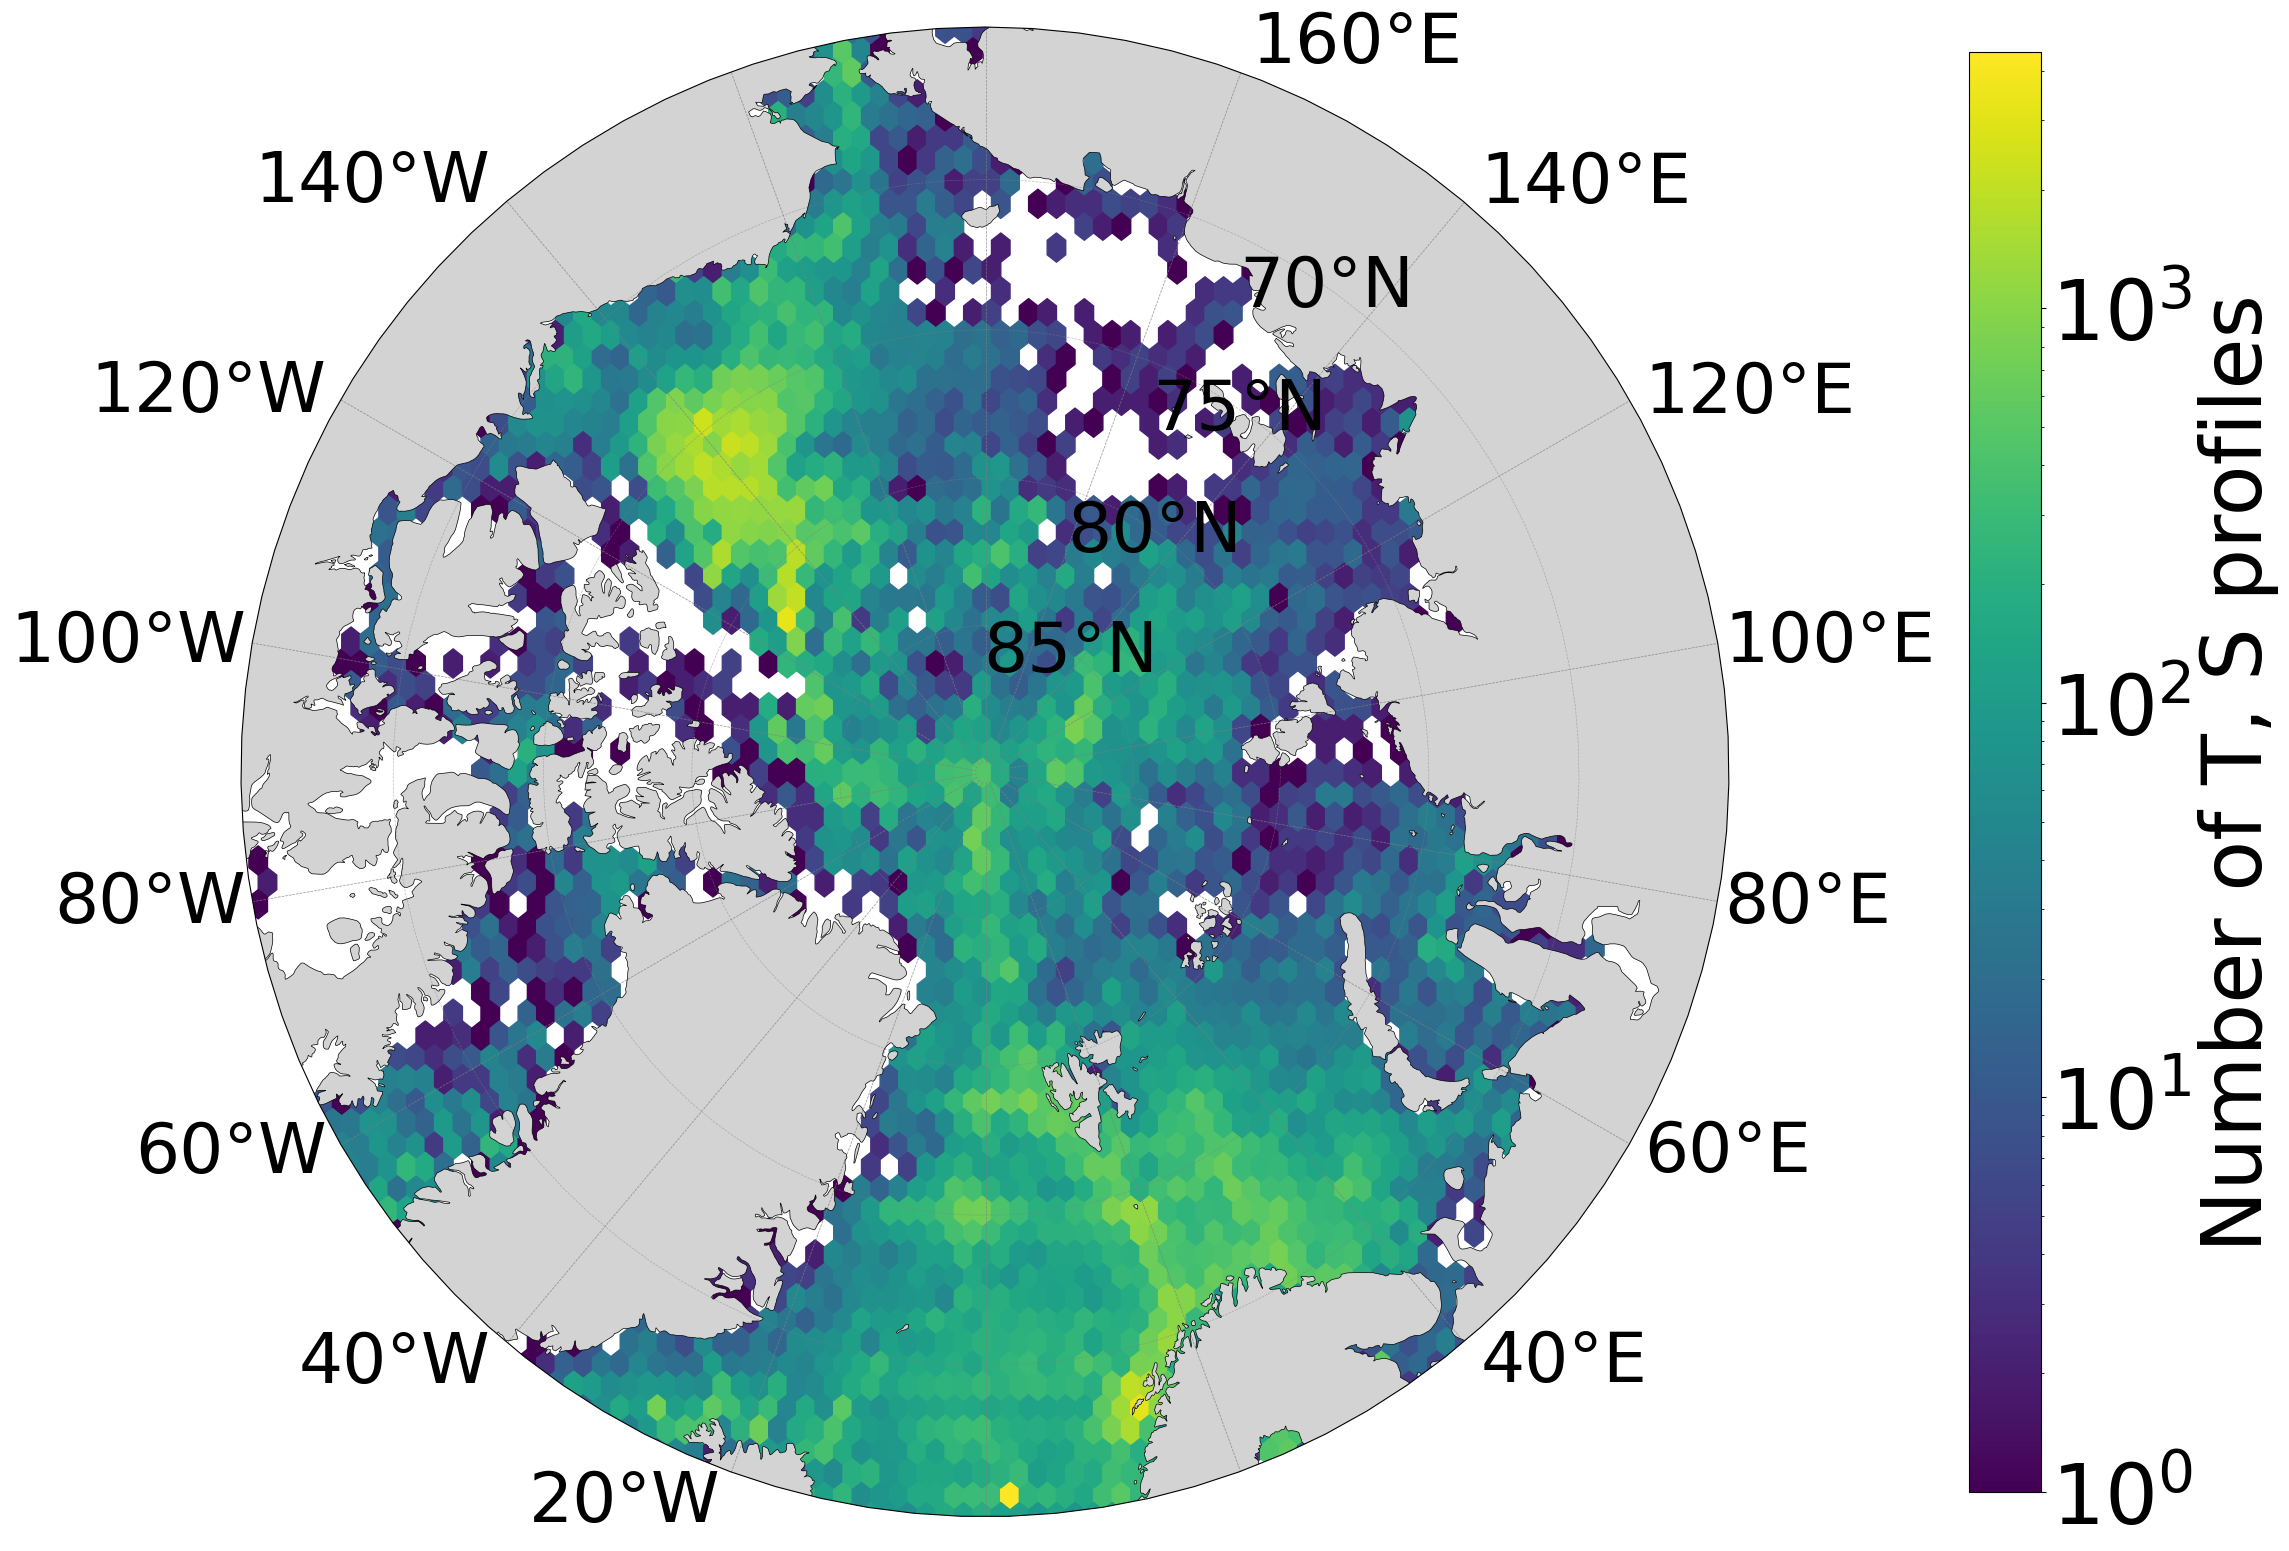

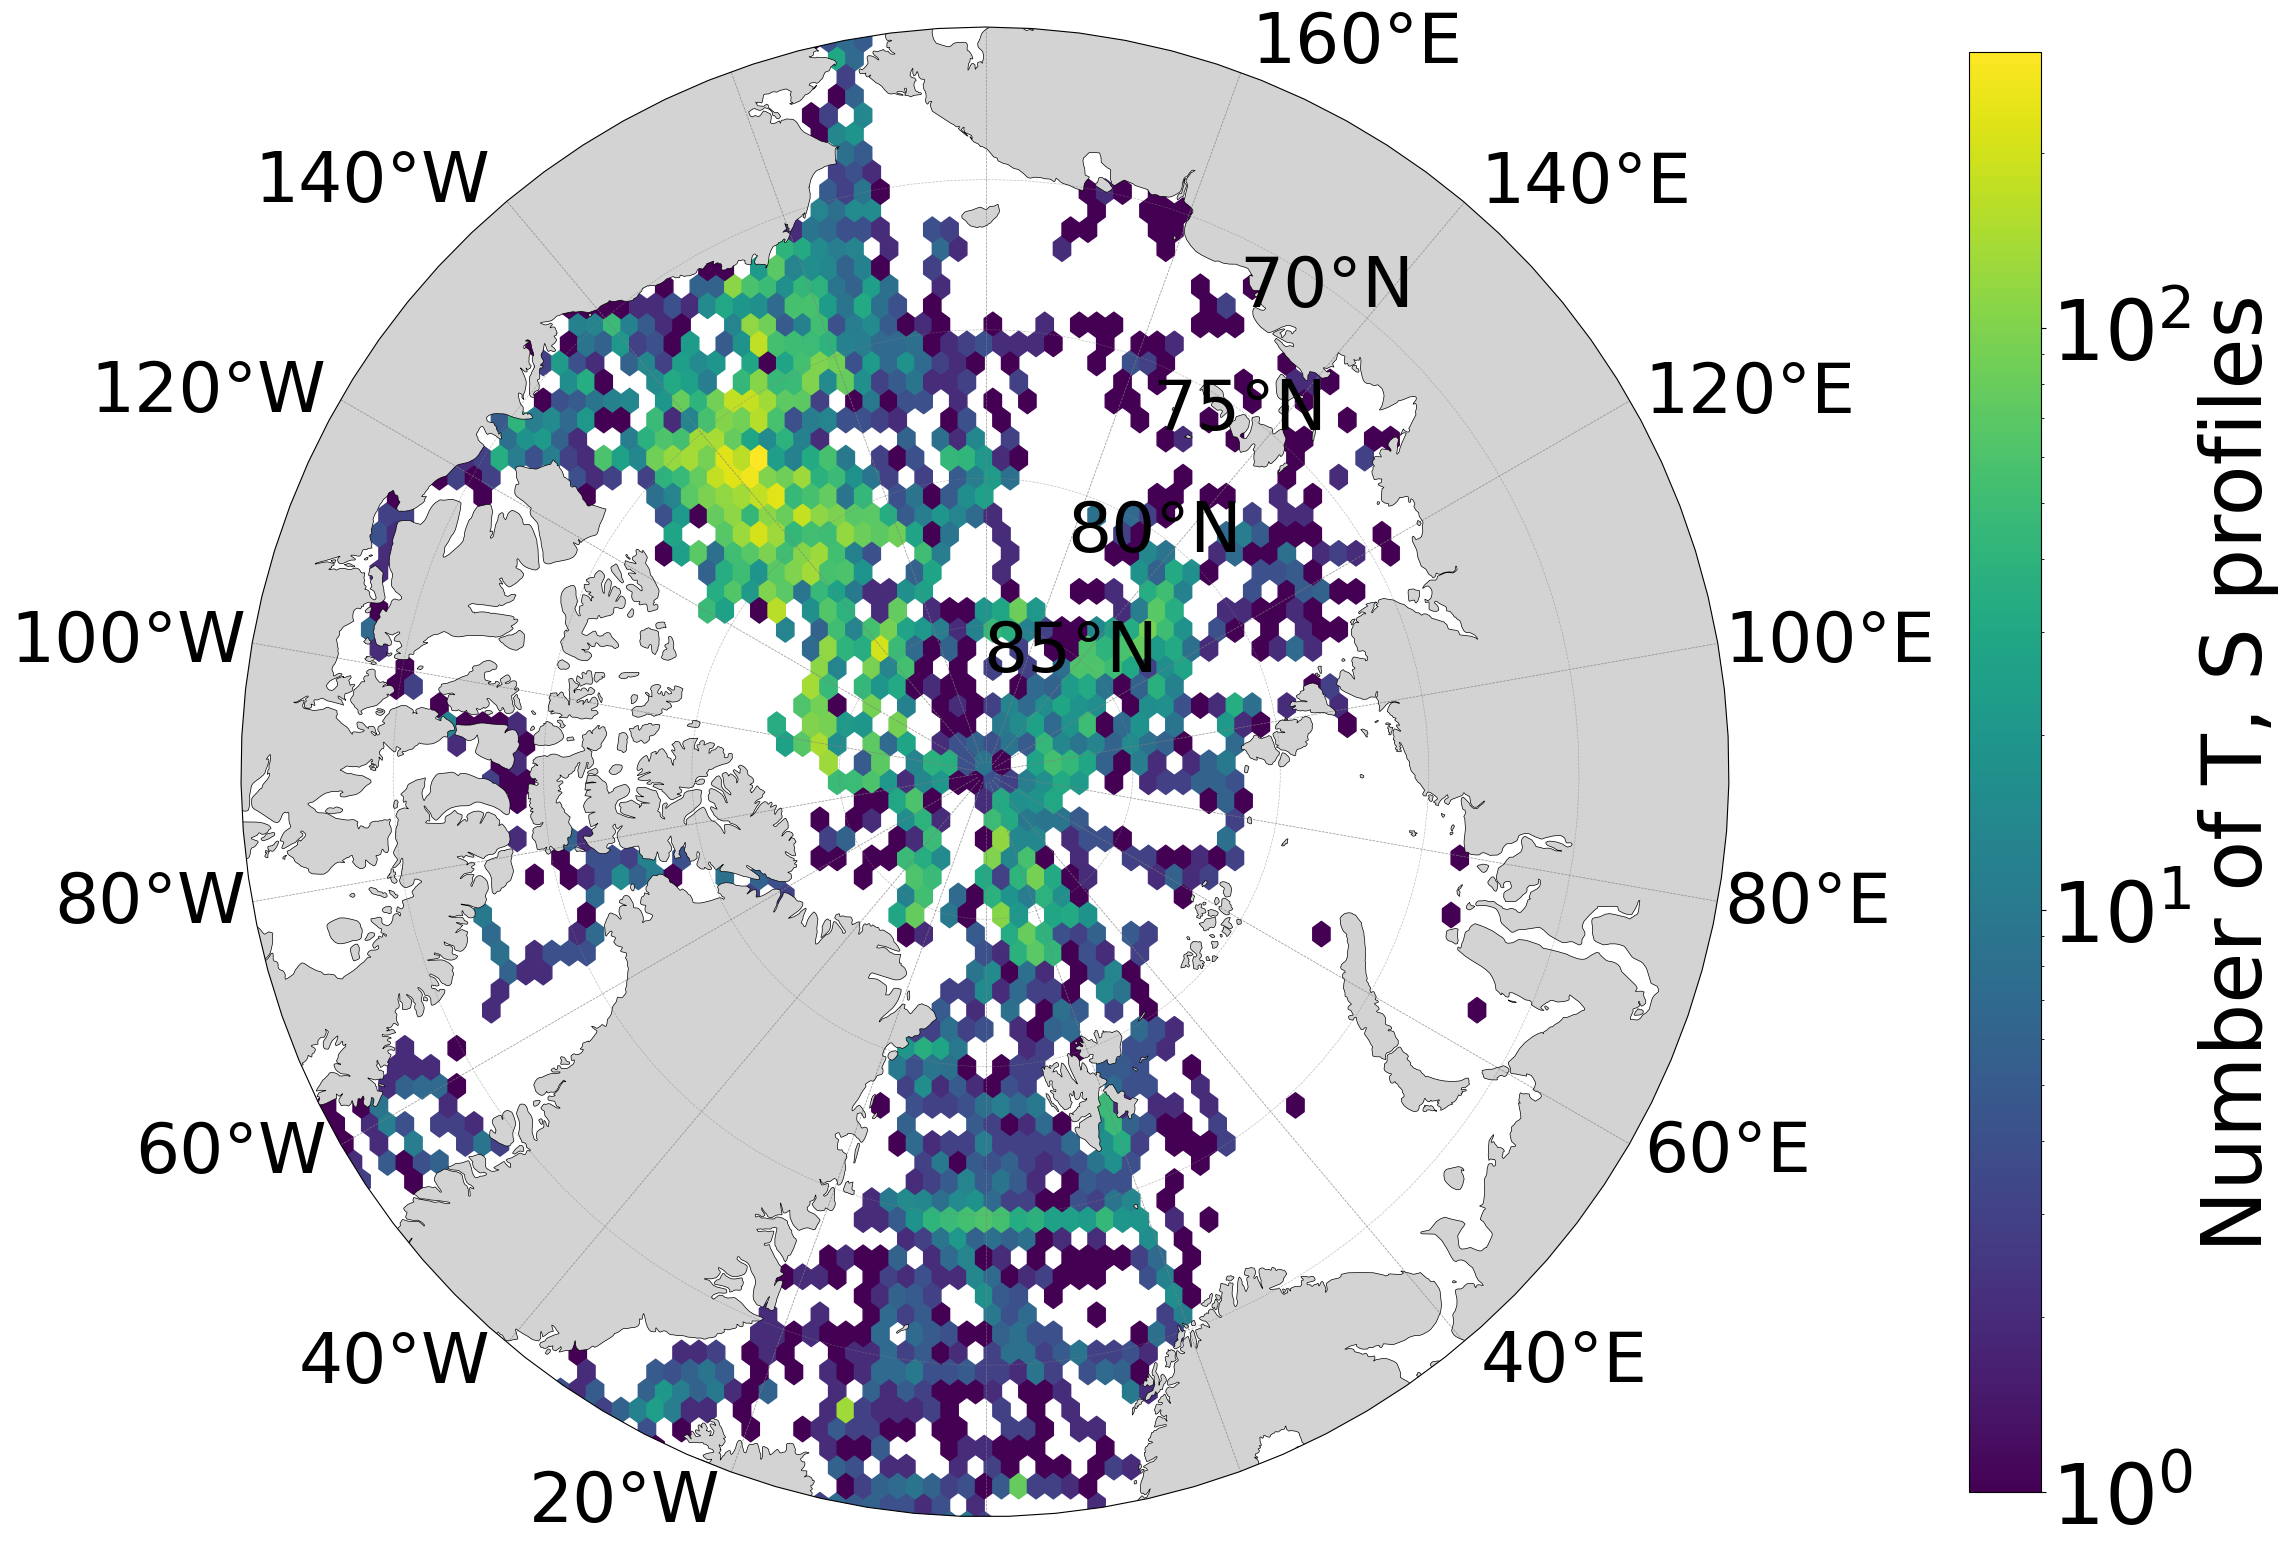

In [42]:
import os
import sys
sys.path.append('/Users/ko389/Documents/Arctic_Water_Masses/Functions_general')
from paper_plots import plot_spatial_dis_map

#Plot of all T-S data
plot_spatial_dis_map(arctic)
#Plot of all DO data
plot_spatial_dis_map(arctic.dropna(subset=['dissolved_oxygen']))

/var/folders/zn/185xql1x357249zc9q1yjqvm0000gq/T/ipykernel_83419/530723397.py:27: UserWarning: The following kwargs were not used by contour: 'linestyle'
  contour = ax.contour(SA, CT, sigma0, levels=levels, linestyle='--', colors='gray')


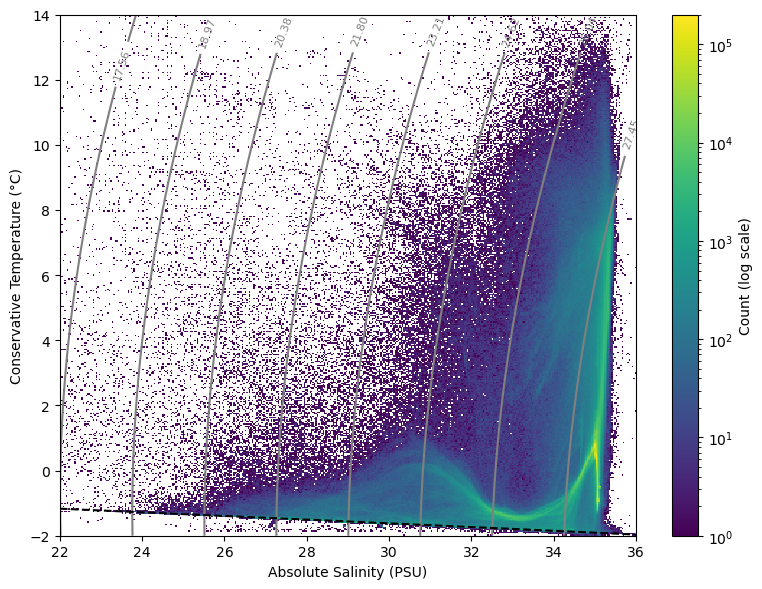

In [138]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import numpy as np
import seaborn as sn
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo
import pandas as pd
import gsw
from matplotlib.colors import LogNorm

def create_TS_bivariate_histogram_no_values(data):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bivariate histogram for Conservative Temperature vs Absolute Salinity
    hist = ax.hist2d(data['absolute_salinity'], data['conservative_temperature'], bins=(np.linspace(22, 36, 400), np.linspace(-2, 14, 400)), cmap='viridis', norm=LogNorm())

    # Calculate sigma0 density for the entire plot area
    SA, CT = np.meshgrid(np.linspace(22, 36, 400), np.linspace(-2, 14, 400))
    sigma0 = gsw.sigma0(SA, CT)

    # Add contours of sigma0 density
    levels = np.linspace(np.min(sigma0), np.max(sigma0), 10)
    contour = ax.contour(SA, CT, sigma0, levels=levels, linestyle='--', colors='gray')
    # Add contour label
    ax.clabel(contour, inline=True, fontsize=8)

    # Add freezing line for seawater in Arctic Ocean
    CT_freezing = gsw.CT_freezing(np.linspace(22, 36, 400), 0, 0)
    ax.plot(np.linspace(22, 36, 400), CT_freezing, linestyle='--', color='black')

    # Set labels and limits
    ax.set_xlabel('Absolute Salinity (PSU)')
    ax.set_ylabel('Conservative Temperature (\u00b0C)')
    ax.set_xlim([22, 36])
    ax.set_ylim([-2, 14])
    
    # Add colorbar
    cbar = plt.colorbar(hist[3], ax=ax)
    cbar.set_label('Count (log scale)')

    # Remove grid axes      
    plt.grid(False)
    plt.tight_layout()
    plt.show()

create_TS_bivariate_histogram_no_values(arctic)
